In [116]:
%run analysis_functions.ipynb

# Analysis

In this particular notebook, I'll be explaining which tools I used to analyze the models and how I interpreted them, but before it's necessary to clarify some details of the model.

Previously in the general description of this project, I mentioned that there are 3 different input variables, to make different models, where the binary maps are changed in size. To be more specific about this, if the binary map has an NxN size I take a subset of it with mxm size. this subset is built around the "head" of the snake defining a radius measured in units of squares. Using this strategy it doesn't matter how big is the real game because the model will always receive the same "sight matrix" for the input variables.

For all the models I select a size for the game of 30X30  squares and the sight matrix can variate from 1, 2, or 3 squares of radius depend on the model, with this sizes I can use the same network architecture for all the models (using the recommendation of 2^n neurons, around 128 in this case with three layers). Although using the first architecture without some tunning process is something unusual is necessary to be able to compare the different input variables and policies.

In [2]:
SNAKE_GAMES = [SnakeAI([30,30], 3)]

The model will play the game under certain behavior ruled by the policies (rewards and punishments) we defined and considered relevant for the case of study. For this game I only used 3 occasions where the snake is rewarded or punished:

- approximation: Reward if the snake gets one step closer to the prey and punish if gets one step further.
- eat: Reward if the snake eats the prey.
- dead: Punish if the snake died.

Varying the values of the rewards and punishments we will change how the model builds the strategies to play the game. To define the next policies I centered in made them different enough in magnitude and sign between each other and between the parameters always having in mind the logic of the game.

Mixing the variations in the sight matrix and the policies, now we can study how these changes will affect the behavior of the snake strategy, principally I'll focus on four points how many points will get, how many steps will endure, how fast get the points and the relationship between the points and the steps. 


In [3]:
REWARDS = [{
            'aprox': [1,0],
            'eat':[10,0],
            'dead':[-100, 0]
            },
            {
            'aprox': [1,0],
            'eat':[10,0],
            'dead':[-10, 0]
            },
            {
            'aprox': [1,-1],
            'eat':[10,0],
            'dead':[-100, 0]
            },
            {
            'aprox': [3,-1],
            'eat':[10,0],
            'dead':[-100, 0]
            },
            {
            'aprox': [1,0],
            'eat':[20,0],
            'dead':[-10, 0]
            },
            {
            'aprox': [3,-1],
            'eat':[20,0],
            'dead':[-10, 0]
            },
    ]

In [4]:
paths = paths_to_data(SNAKE_GAMES, REWARDS)

From this point on I'll be using the same tools for each one of the models so, in order to avoid repetitive conclusions, I'm only going to write in the first policy and finally in the overall discussion.

## First Policy

### Data from training 

The next charts are represented the training process for the first policy with 3 iterations, so the first thing I will explain is, why to do that? if technically execute the same model will lead to the same result but there are some little differences in each iteration that change the final result.

The first thing that changes the results is the initialization of the neural network parameters and the second one is the training data. The deep q-network train and plays the game at the same time for this reason the data is constantly updated (this is something defined in the training process), in particular, this game was built to generate random states (since every time the snake eats the prey the next prey is randomly located and adding the previous decisions of the player such as movements and score, will result practically in a different state each time), considering this fact every match is potentially different from others.

Considering the randomness of these two facts it's necessary to execute a lot of tests to guarantee that we are taking the best decision possible and not being guided by one lucky try. This is something very usual in real applications because were taking advantage of the law of large numbers trying to assure that the results we see are what we can expect in the long term. That's why we can't have the same result every try but at least we can establish some boundaries, something similar to how we establish if a real person is good at something.

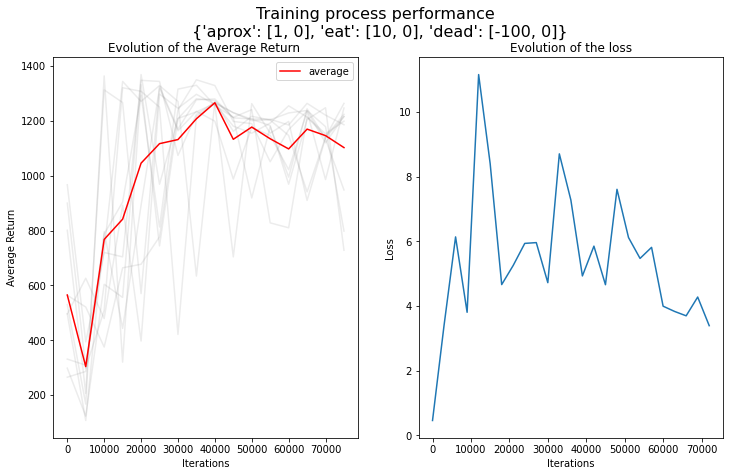

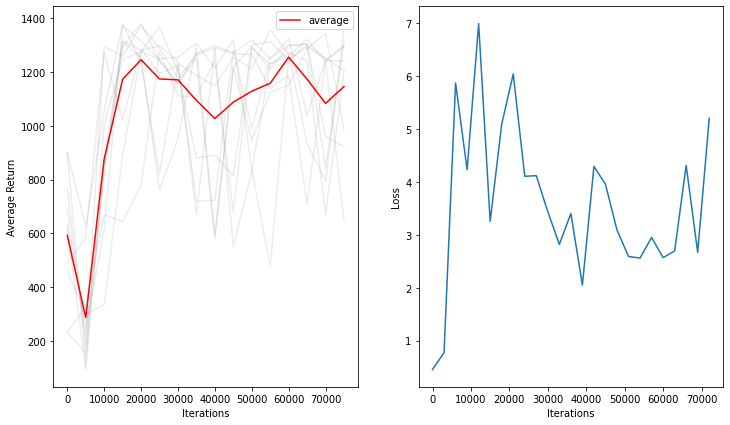

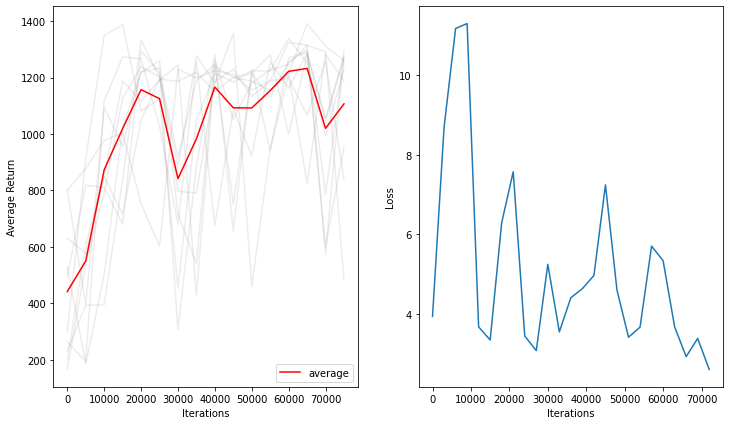

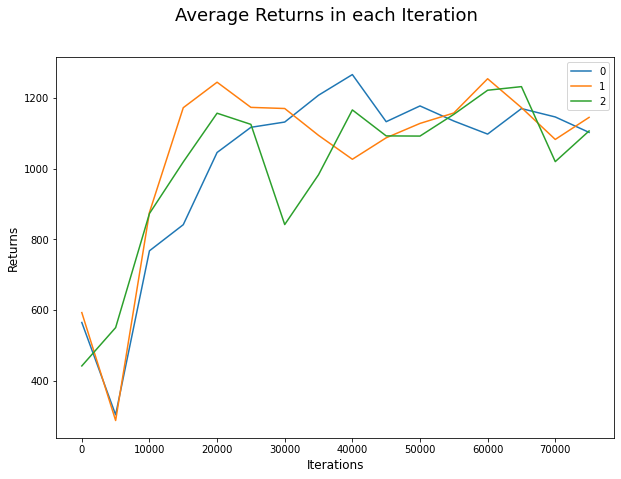

In [5]:
general_sample_visualization(paths, 0)
average_comparative(paths, 0)

### Samples of each iteration

In the previous charts we saw the average response of different model iterations while they were training now we need to analyze in more detail the 'final' model of each one, I gather more samples of the model playing the game with the objective of study the behavior that the "final model" could have in general.

Not in every game the model will get the same results, always there will be some amount of variation that could difficult the predictions of the model results. although we could think that all the iterations will have the same behaviour it is not, at least with the current number of iterations per model then to select the best model from the available iterations is necessary to test them statistically speaking.

In [6]:
df_0 = samples_per_iteration(0,500)

To start the tests we need to clean the data first, the cleaning process is very easy, we only need to delete the "weird" results like those where the model stuck in a cycle repeating the same steps over and over (The samples have a maximum of 30000 steps). This is something common that could happen while we test the different policies. This case happens because the model doesn't have memory, in each step the model receives a new state and chooses one action that maximizes the reward but doesn't care about the previously taken steps.

There are a lot of methods to delete the outliers from the data I'll be using the interquartile range to determine which samples must be considered as something unusual and which not.

To represent the number of samples I'll be using histograms marking the average reward and its deviation. At a first sight, it seems that the reward of all the taken samples follows a normal distribution.

/usr/lib/python3/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/lib/python3/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


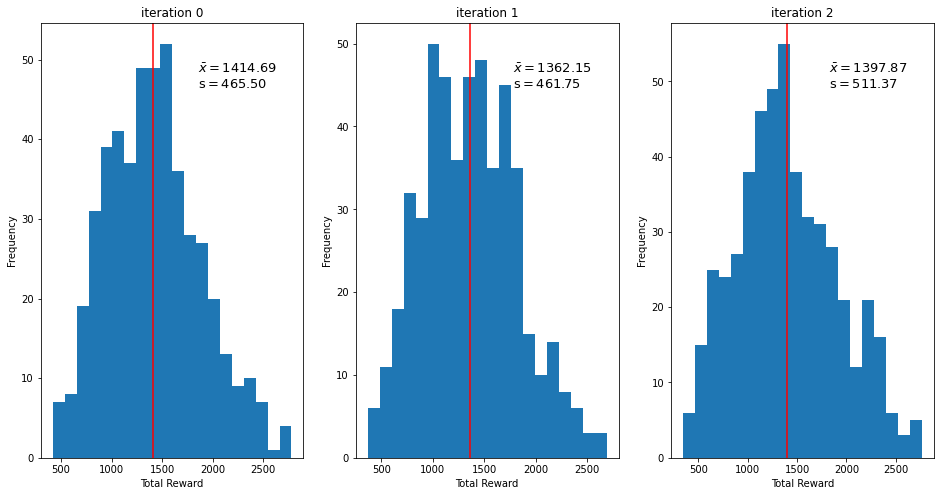

In [7]:
delete_outliers_df(df_0)
histogram(df_0,20)

If the data follows a normal distribution then it will simplify a lot of tests, since the majority of them require this as a condition to assure that the conclusions are trustworthy. Here I applied the method implemented in scipy, which considers the normality of the data as the null hypothesis (means that if the p-value is lower than the threshold we defined then the distribution isn't normally distributed). One of the assumptions I made while doing this test was to use ranges instead of the individual values, otherwise, I would have needed a lot more samples to get more consistency in the response. Using ranges as the values to evaluate reduces the amount of data we need but also we lose precision.

In [8]:
checkNormalityModels(df_0)

The iteration 0 is normal with 0.09276274790859089 of confidence
The iteration 1 is normal with 0.00848847670978256 of confidence
The iteration 2 is normal with 0.6613902895312096 of confidence


now having the certainty about the distributions we can compare them statistically using the ANOVA test where we eval if at least one of the samples came from a different distribution. Theoretically, if we run the same neural network with enough iterations and data for each training the results must be similar enough to can't distinguish one set of samples from each other.

One key point about how to interpret this type of tests is the criteria of the researcher because even if the results are positive or negative if the value is close to the predefined threshold (in this case 0.05), for whichever of both sides, then the results aren't too trustworthy and we need to rely more on the criteria, intuition, and experience.

In [9]:
anovaTestModels(df_0)

F_onewayResult(statistic=1.5351577177224025, pvalue=0.21576500643810329)


Independently from the results from the ANOVA test we only need one of the model iterations so we need to choose the best, since there are only 3 iterations is easy to determine which one is the best. I decided that the best iteration is which has the greater average with the less variation since I think that the best model beyond the maximum results is the model easier to predict.

## Samples (Data from the game)

Previously the results were about the rewards of the models, which represents how "good" is the model to maximize that specific policy but doesn't represent how the model plays the game exactly, although the next analysis isn't related to the neural network directly are related to how is the truth performance while playing the game.

The first thing to clarify is what data we have available like it is a simple game and I want to study the evolution over time I decided to select two variables, the score (number of points get it by the player) and the number of steps (each time that the model takes a decision is considered one step).

In [10]:
games = sampler(SNAKE_GAMES[0], REWARDS[0], 0, 0, 500, True)

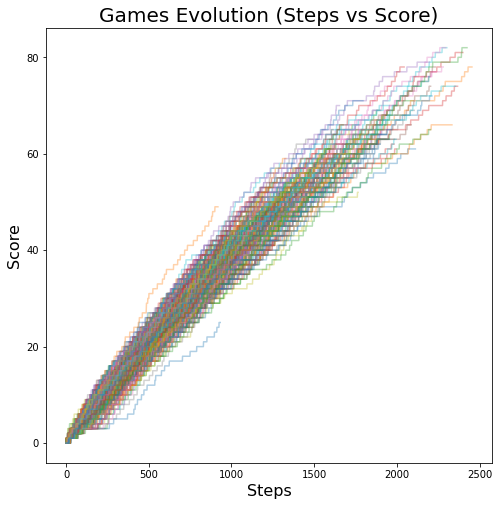

In [11]:
games = deleteStuckGames(games)
plotPathGames(games)

In [129]:
steps_0, score = stepsScoreValues(games)

## Histograms

In the next charts, the variables are represented individually and in conjunction using histograms in 1D and 2D. Now we don't care too much about the exact distribution of the data but is necessary to analyze some basic descriptive statistics such as the maximums, minimums, averages, and deviations. Using the above line plot and the 2D histogram we can presume a relation between the two variables that I going to analyze further next.

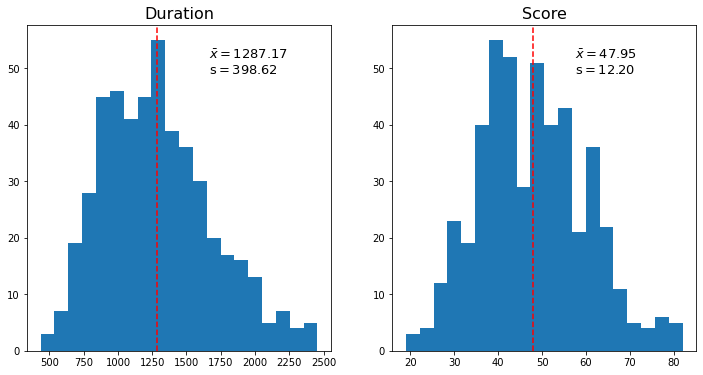

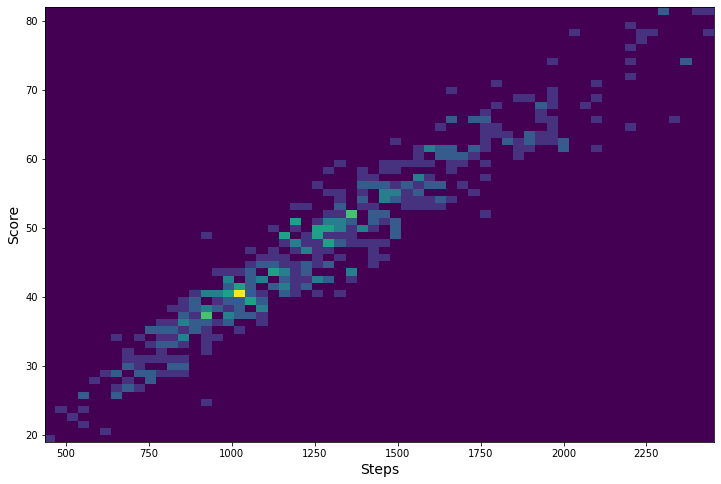

In [130]:
response_histogram(steps_0, score)

## Points vs duration scatter plot

Since I only using two variables then the best analysis possible is a simple regression but from the previous charts is easy to think that the relation between the variables is polynomial and not linear, at least not in a direct way but applying a simple transform we can convert it into a linear regression (I'm not going deeper with the transformation but it can be found by hyperbolic linearized estimates)

The next 4 charts are represented the linearized view and the real view of the regression with their respective residuals, in both representations we can distinguish two important things. The first one is that the regression seems to fit the data almost perfectly and the second one is related to the residuals if we look closely the variation of the residuals increase, which means it isn't constant which is a contradiction to the requirements of a regression. This gives us an important conclusion about the regression, although at a first sight the technique seems to have good results will only work on a determined interval where the variation is normally distributed with a constant variation (for the residuals) beyond that point predictions are unstable.

The regression technique is easy to use and easy to interpret but is necessary to understand the basic principles of the theory to applied correctly, since the regression only works over a reduced interval because of its limitations there exists other techniques that overcome this type of limitations and allow us to study in detail why this behavior may occur like the quantile regression.

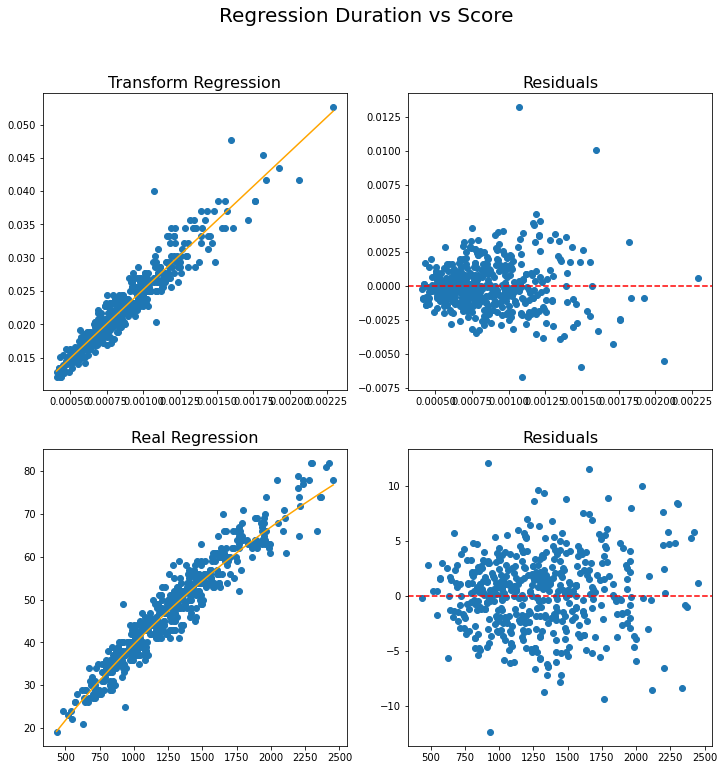

In [131]:
transform_0, real_0, x_0 = transformRegression(steps_0,score)

## Time between points 

With the relation between the score and steps already presented before now, I'll be analyzing a little further the time variable, in this case the time is discretized by steps that are integer numbers. The first thing I come up with working with variables related to time is to model it as a Poisson process, such process requires three conditions:

- The average rate is constant
- Two events cannot occur at the same period
- The events must be independent of each other 

To model the time variable we have a few options, the most used ones are the exponential distribution and the gamma distribution which answer two related but different questions, meanwhile the exponential distribution answer to the time until the first event, the gamma distribution answer to the time between n events.

Using the gamma distribution to modeling the time now we can compare which policies are faster than the others in a more rigorous way.

In [15]:
duration_diff = time_diff(games)

In [16]:
duration_diff = delete_outliers(duration_diff)

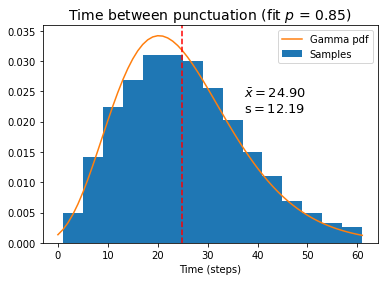

In [17]:
pdf_0 = gamma_aproximation(duration_diff)

## Survival Analysis

Since we have all the process of each game for a set of games we can run a survival analysis, where we eval the behavior not as an individual but as a population and we want to answer what proportion of the population will survive past an n number of time. In the chart is the survival probability curve with its confidence intervals (95%). Now we can calculate the amount of players or the probability to survive over time, for example, the median of the population (50%) survives nearly 1250 steps, 100% of the tests survive at least 500 steps and less than 10% survives more than 1800 steps.

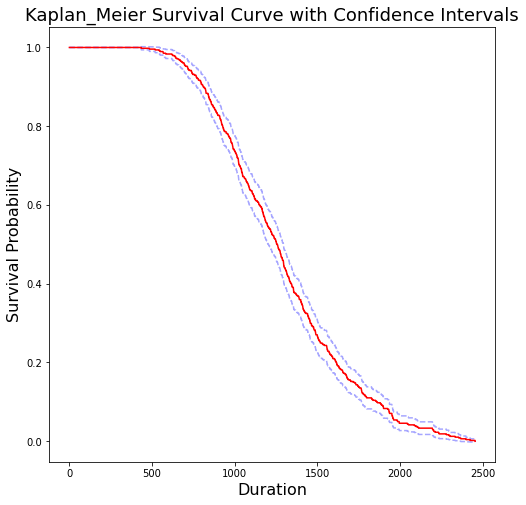

In [132]:
up, down, probs, steps_range = survival_analysis(steps_0)

With the previous three procedures now we have a quantitative way to compare the policies. With the gamma distribution we can study the speed to collect points, with the survival analysis we can study an overall probability of how many time we can expect the game to lasts and finally with the regression we can study again the speed the model have to gain points and the relationship between the time and the number of points that probably will get.

## Second Reward

### Data from training 

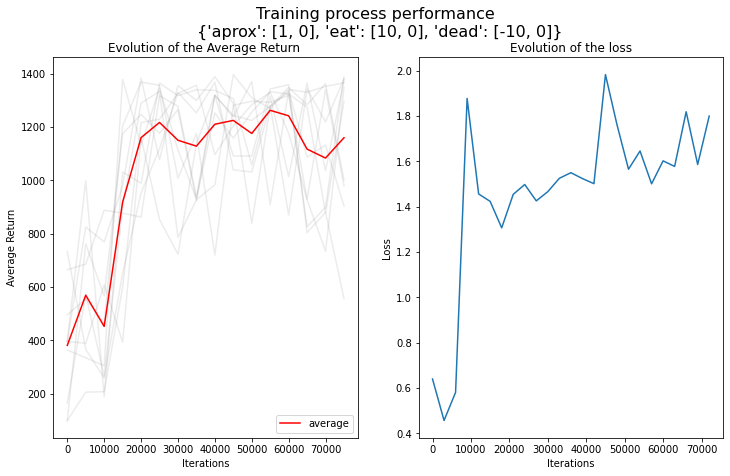

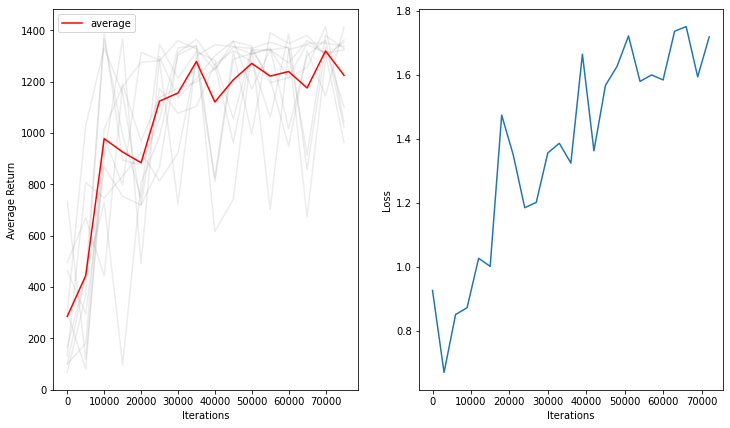

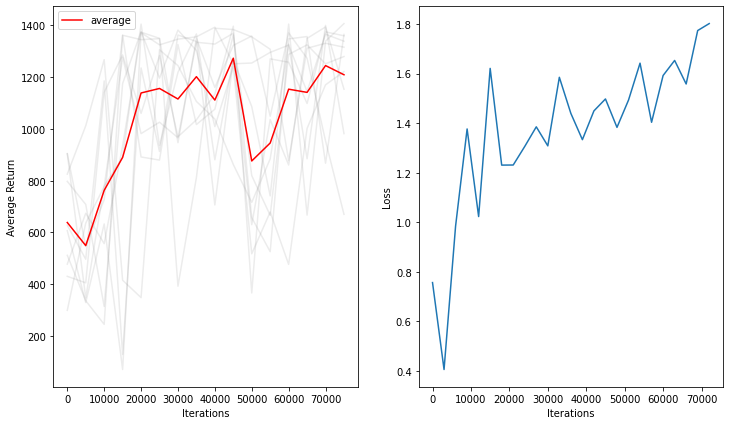

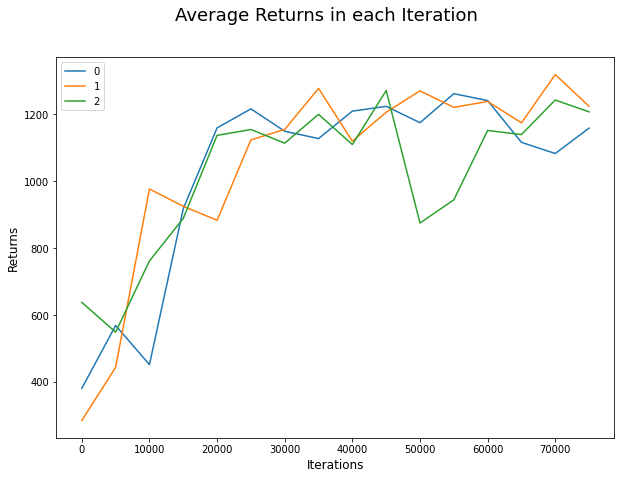

In [19]:
general_sample_visualization(paths, 1)
average_comparative(paths, 1)

In [20]:
df_1 = samples_per_iteration(1,500)

/usr/lib/python3/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/lib/python3/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


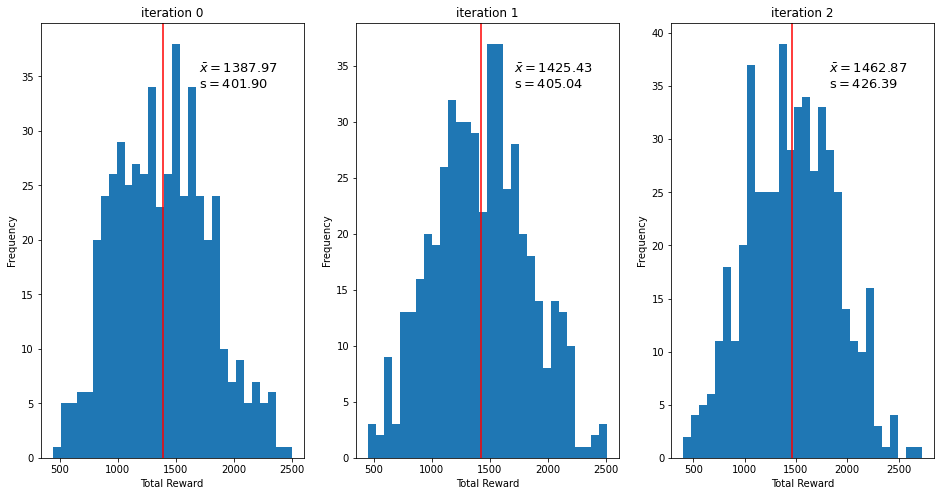

In [21]:
delete_outliers_df(df_1)
histogram(df_1,30)

In [23]:
checkNormalityModels(df_1)

The iteration 0 is normal with 0.00783360955349034 of confidence
The iteration 1 is normal with 0.2219249809169785 of confidence
The iteration 2 is normal with 0.013378106070820812 of confidence


In [26]:
anovaTestModels(df_1)

F_onewayResult(statistic=4.124588705160677, pvalue=0.01635501553000083)


### Evaluate the model response 

In [27]:
games_1 = sampler(SNAKE_GAMES[0], REWARDS[1], 1, 0, 500, True)

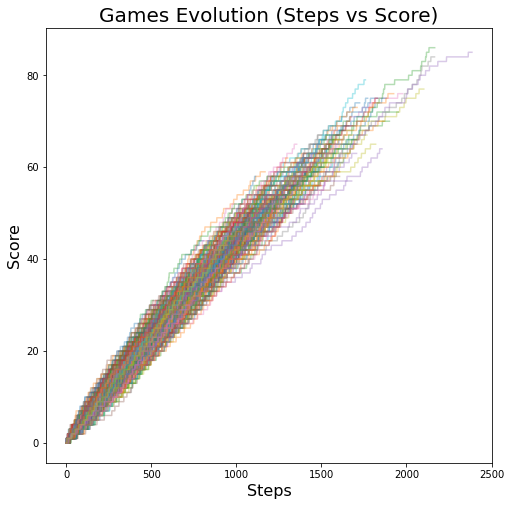

In [97]:
games_1 = deleteStuckGames(games_1)
plotPathGames(games_1)

In [98]:
steps_1, score_1 = stepsScoreValues(games_1)

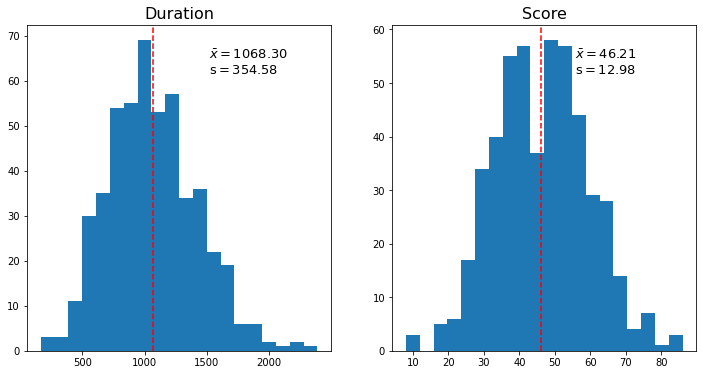

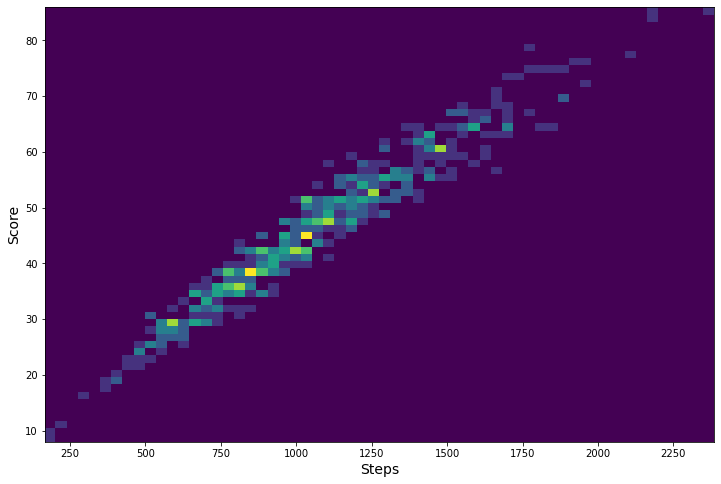

In [99]:
response_histogram(steps_1, score_1)

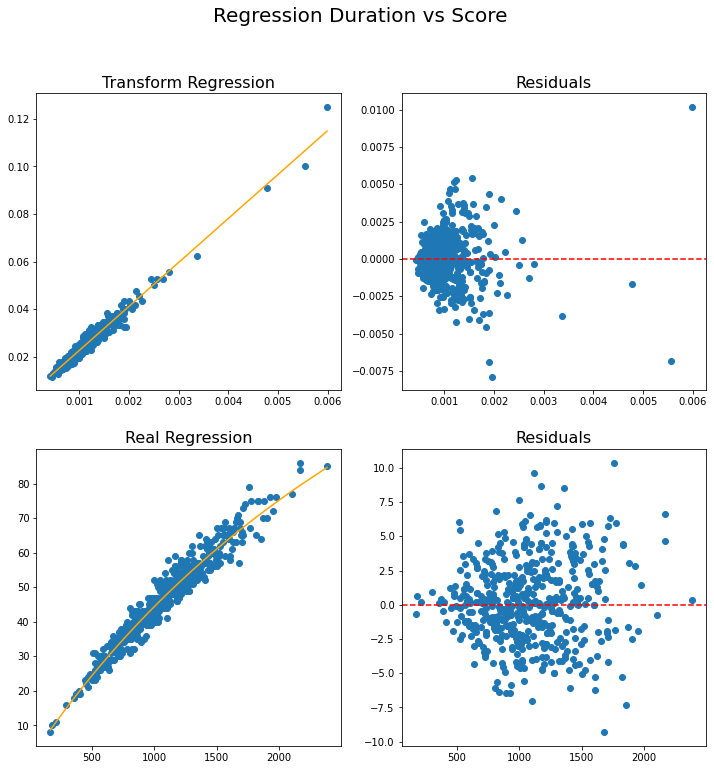

In [121]:
transform_1, real_1, x_1 = transformRegression(steps_1,score_1)

In [101]:
duration_diff_1 = time_diff(games_1)

In [102]:
duration_diff_1 = delete_outliers(duration_diff_1)

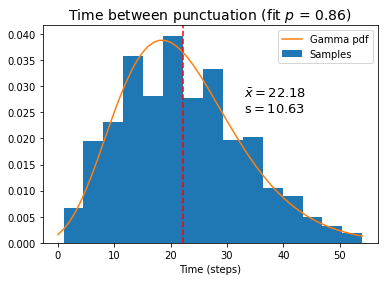

In [103]:
pdf_1 = gamma_aproximation(duration_diff_1)

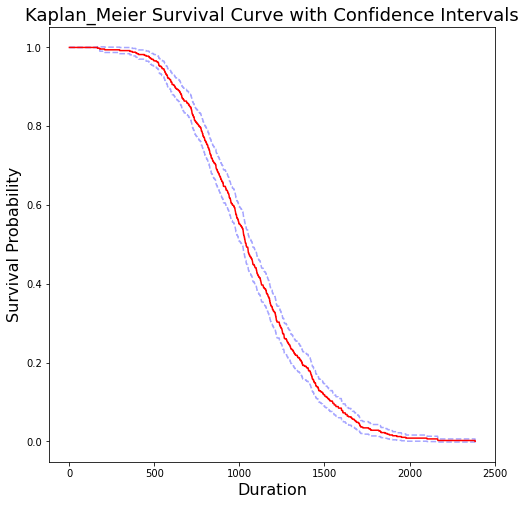

In [104]:
up_1, down_1, probs_1, steps_range_1 = survival_analysis(steps_1)

## Third Reward 

### Data from training 

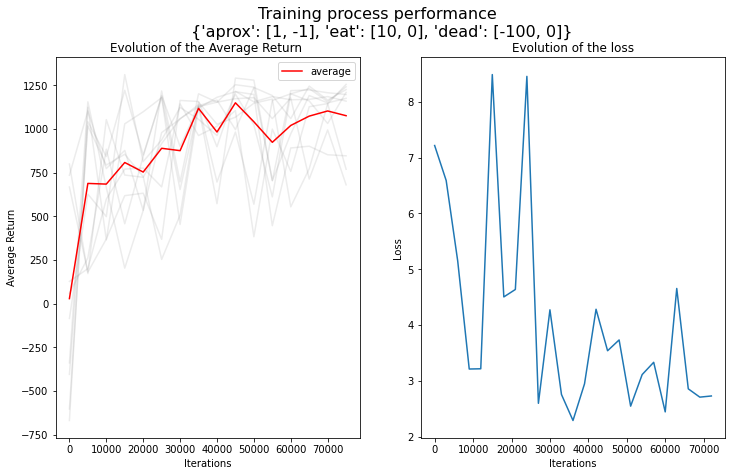

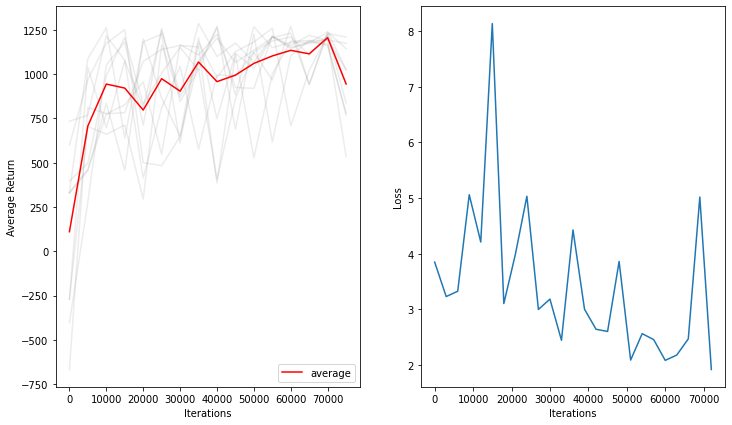

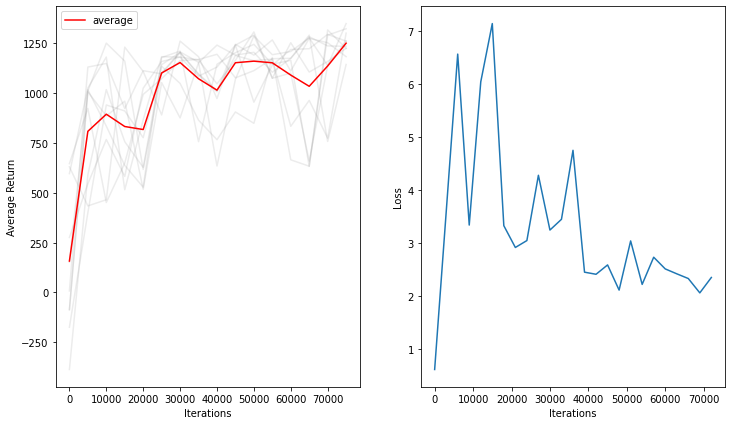

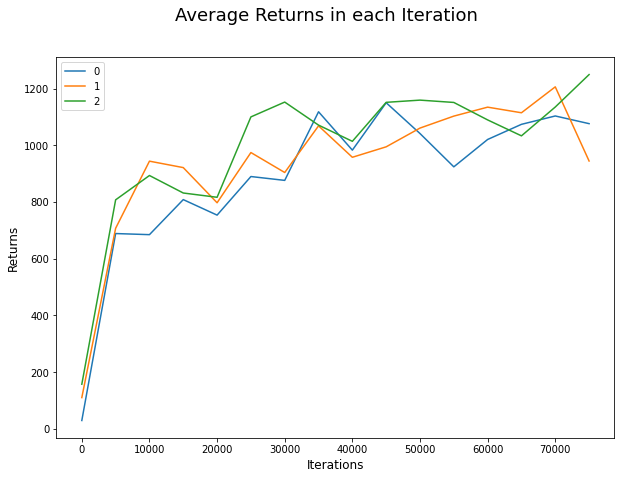

In [36]:
general_sample_visualization(paths, 2)
average_comparative(paths, 2)

### Samples of each iteration

In [37]:
df_2 = samples_per_iteration(2,500)

/usr/lib/python3/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/lib/python3/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


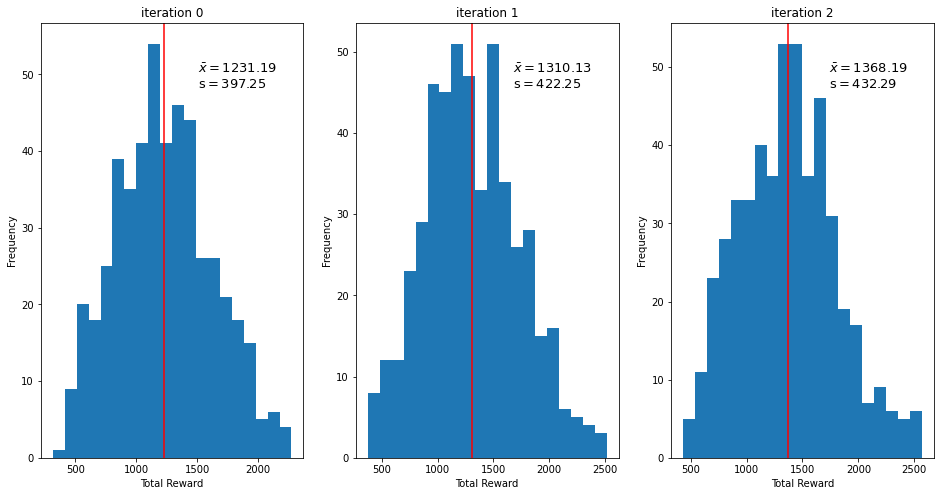

In [38]:
delete_outliers_df(df_2)
histogram(df_2,20)

In [39]:
checkNormalityModels(df_2)

The iteration 0 is normal with 0.3555840339699645 of confidence
The iteration 1 is normal with 0.10126031978278581 of confidence
The iteration 2 is normal with 0.22865330964398162 of confidence


In [40]:
anovaTestModels(df_2)

F_onewayResult(statistic=13.405442129051323, pvalue=1.6987361792805612e-06)


In [41]:
games_2 = sampler(SNAKE_GAMES[0], REWARDS[2], 2, 0, 500, True)

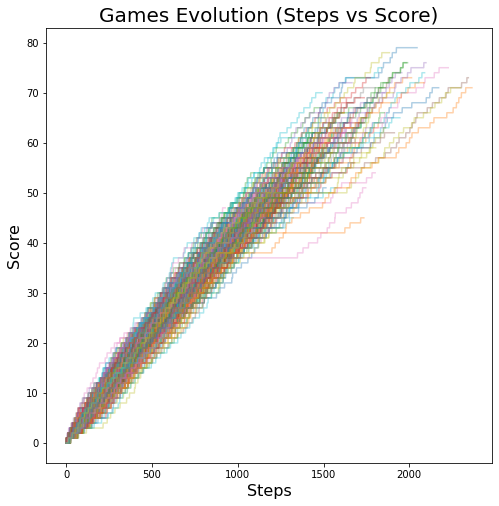

In [42]:
games_2 = deleteStuckGames(games_2)
plotPathGames(games_2)

In [43]:
steps_2, score_2 = stepsScoreValues(games_2)

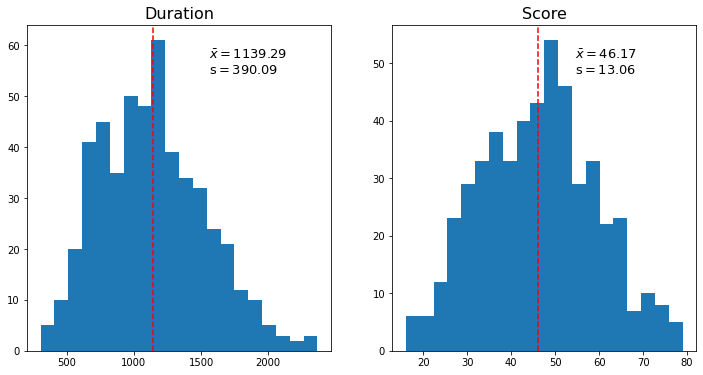

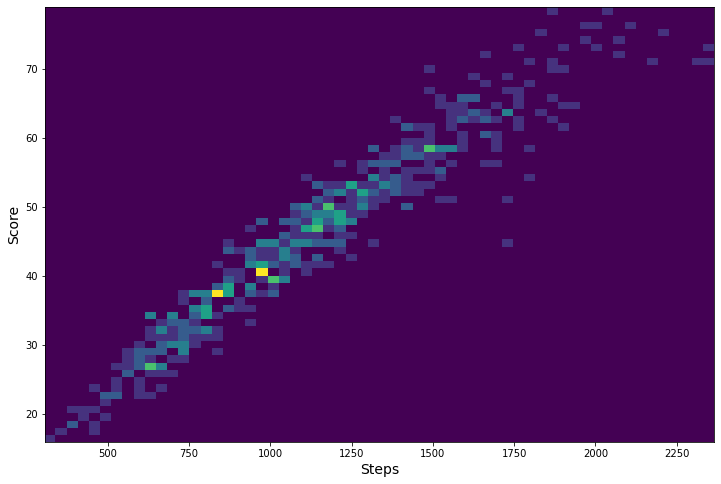

In [44]:
response_histogram(steps_2, score_2)

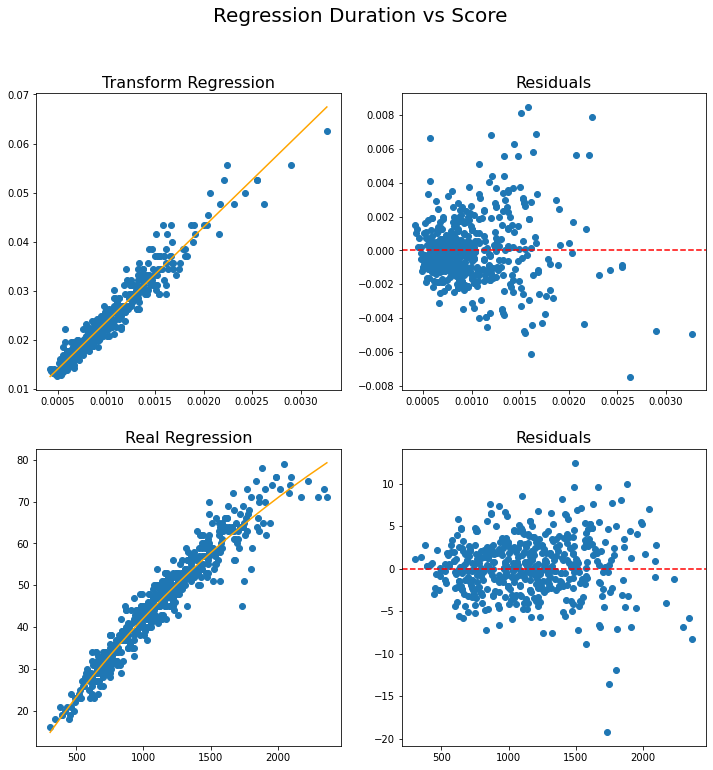

In [122]:
transform_2, real_2, x_2 = transformRegression(steps_2,score_2)

In [46]:
duration_diff_2 = time_diff(games_2)

In [47]:
duration_diff_2 = delete_outliers(duration_diff_2)

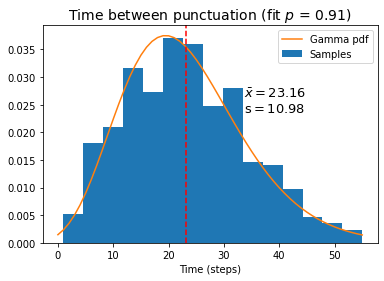

In [48]:
pdf_2 = gamma_aproximation(duration_diff_2)

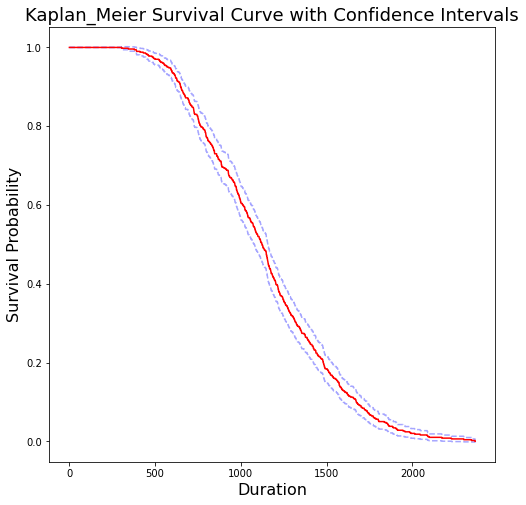

In [49]:
up_2, down_2, probs_2, steps_range_2 = survival_analysis(steps_2)

## Fourth Reward 

### Data from training 

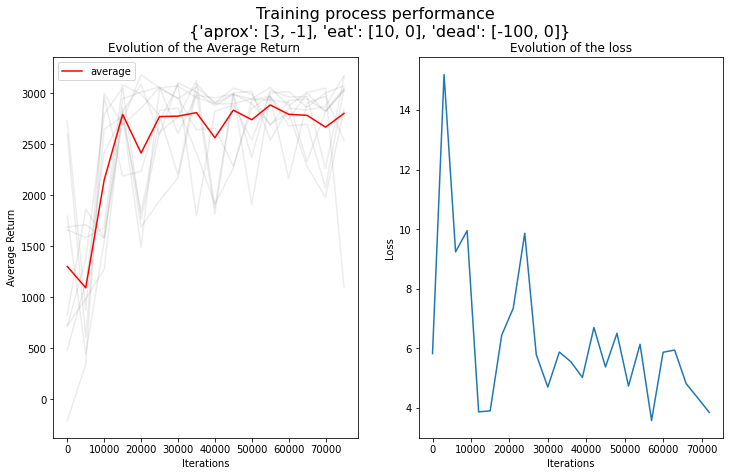

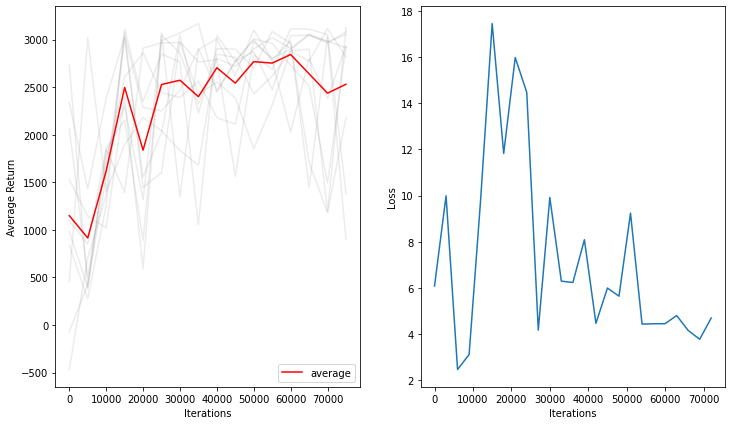

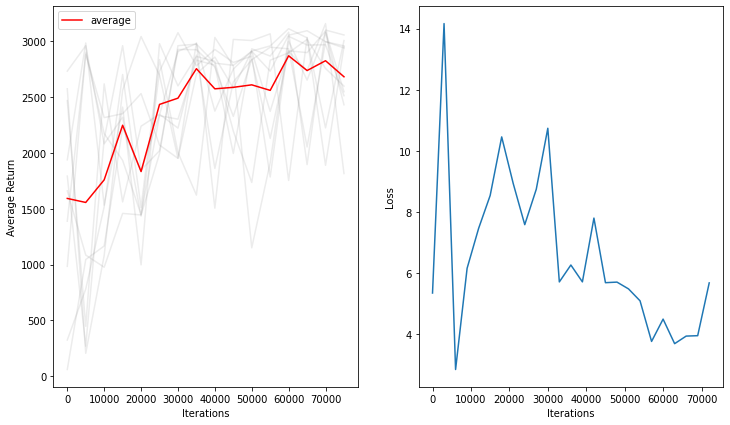

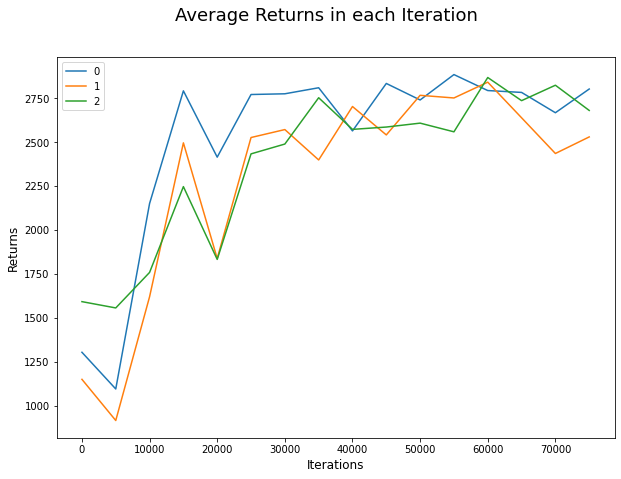

In [50]:
general_sample_visualization(paths, 3)
average_comparative(paths, 3)

### Samples of each iteration

In [51]:
df_3 = samples_per_iteration(3,500)

/usr/lib/python3/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/lib/python3/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


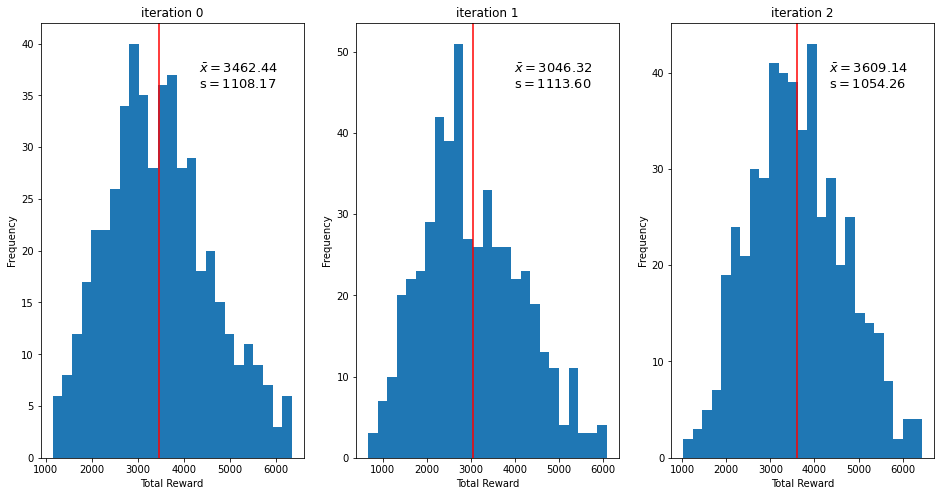

In [52]:
delete_outliers_df(df_3)
histogram(df_3,25)

In [53]:
checkNormalityModels(df_3)

The iteration 0 is normal with 0.2672697693375356 of confidence
The iteration 1 is normal with 0.5723667553469878 of confidence
The iteration 2 is normal with 0.2106098147732939 of confidence


In [55]:
anovaTestModels(df_3)

F_onewayResult(statistic=35.38918522072551, pvalue=9.702093764285787e-16)


In [56]:
games_3 = sampler(SNAKE_GAMES[0], REWARDS[3], 3, 0, 500, True)

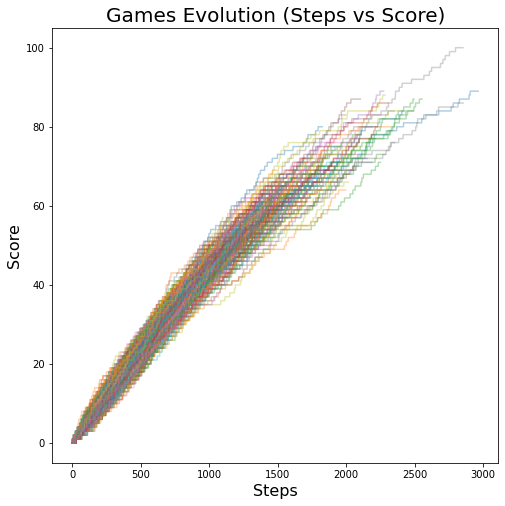

In [57]:
games_3 = deleteStuckGames(games_3)
plotPathGames(games_3)

In [58]:
steps_3, score_3 = stepsScoreValues(games_3)

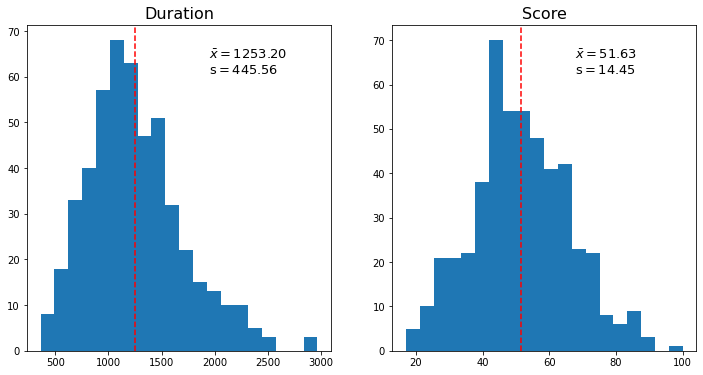

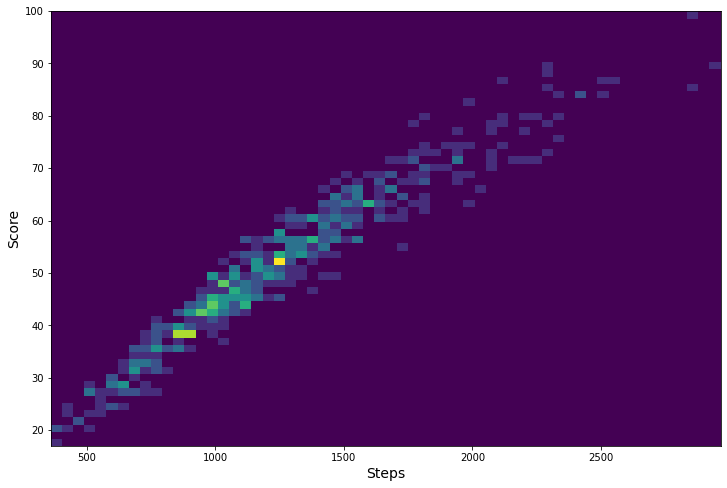

In [59]:
response_histogram(steps_3, score_3)

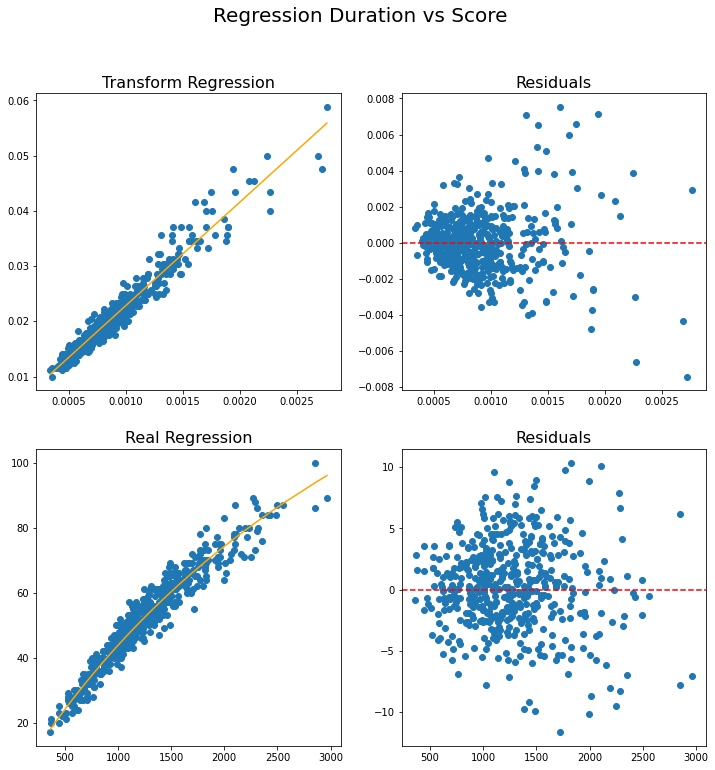

In [123]:
transform_3, real_3, x_3 = transformRegression(steps_3,score_3)

In [61]:
duration_diff_3 = time_diff(games_3)

In [62]:
duration_diff_3 = delete_outliers(duration_diff_3)

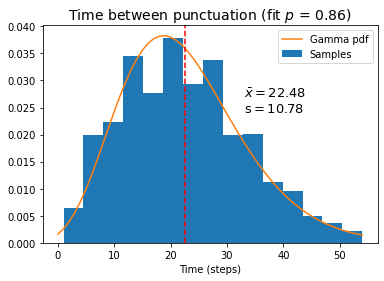

In [63]:
pdf_3 = gamma_aproximation(duration_diff_3)

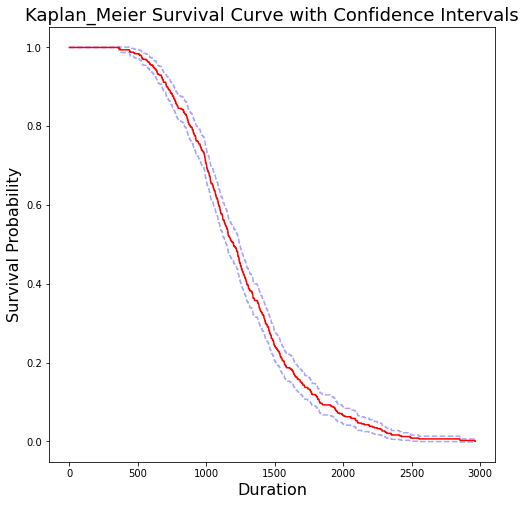

In [64]:
up_3, down_3, probs_3, steps_range_3 = survival_analysis(steps_3)

## Fifth Reward 

### Data from training 

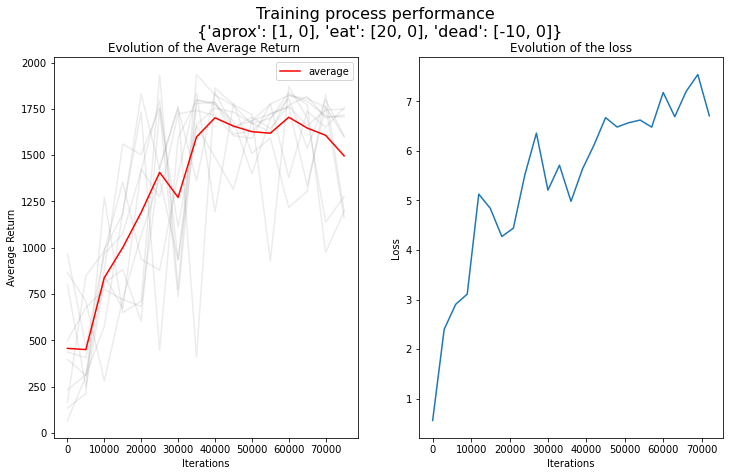

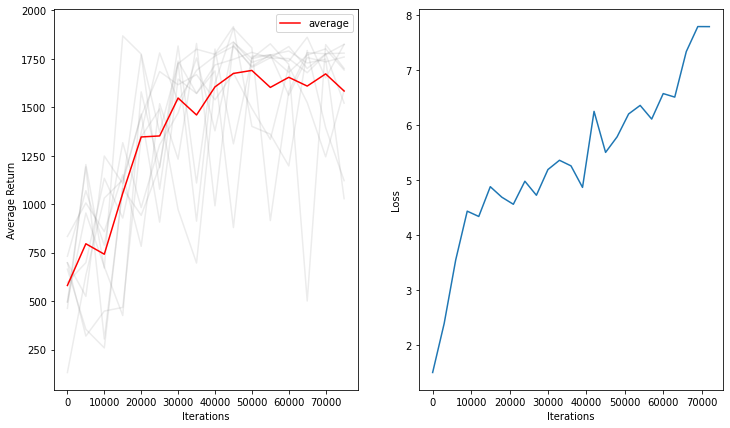

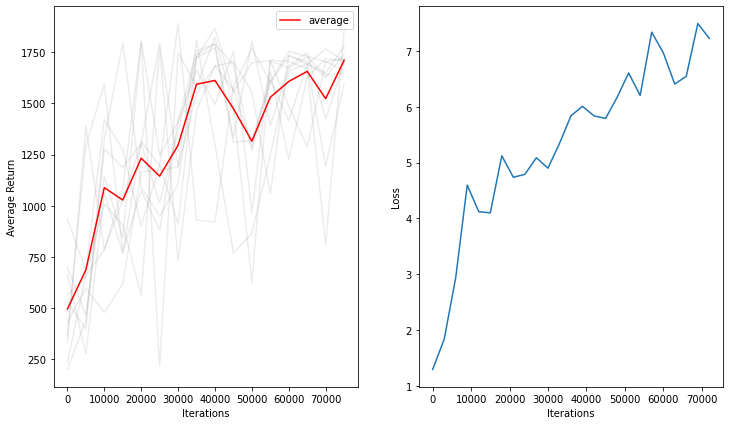

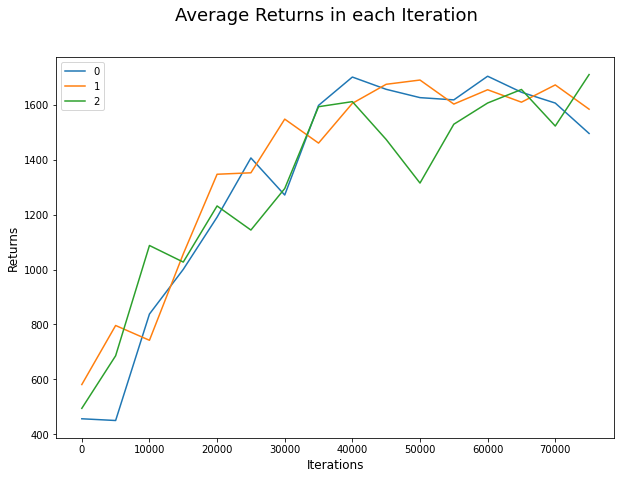

In [65]:
general_sample_visualization(paths, 4)
average_comparative(paths, 4)

In [66]:
df_4 = samples_per_iteration(4,500)

/usr/lib/python3/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/lib/python3/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


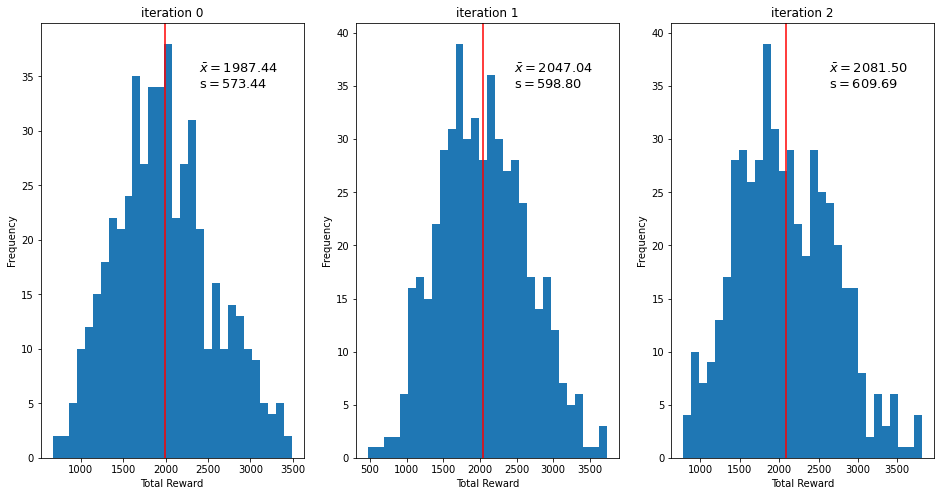

In [67]:
delete_outliers_df(df_4)
histogram(df_4,30)

In [68]:
checkNormalityModels(df_4)

The iteration 0 is normal with 0.4887237933237032 of confidence
The iteration 1 is normal with 0.014862866657303492 of confidence
The iteration 2 is normal with 0.08970888943577321 of confidence


In [69]:
anovaTestModels(df_4)

F_onewayResult(statistic=3.1906994381752907, pvalue=0.041423789276279106)


In [70]:
games_4 = sampler(SNAKE_GAMES[0], REWARDS[4], 4, 0, 500, True)

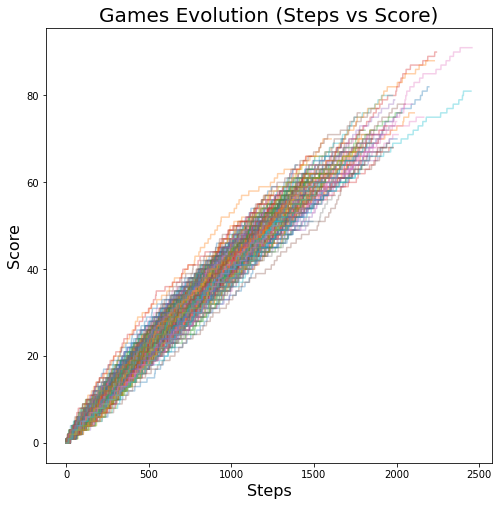

In [71]:
plotPathGames(games_4)

In [72]:
steps_4, score_4 = stepsScoreValues(games_4)

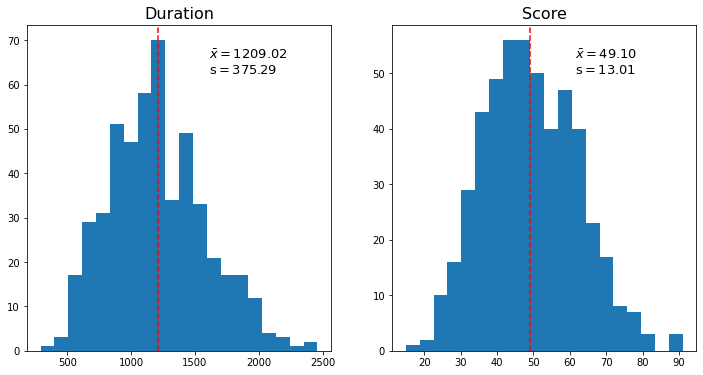

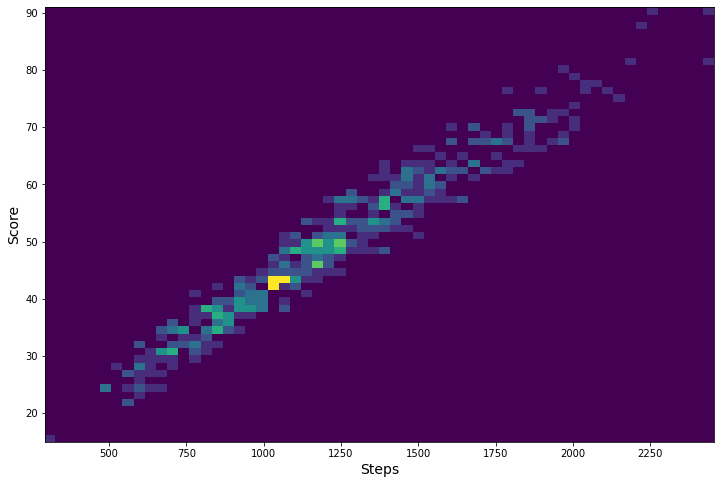

In [73]:
response_histogram(steps_4, score_4)

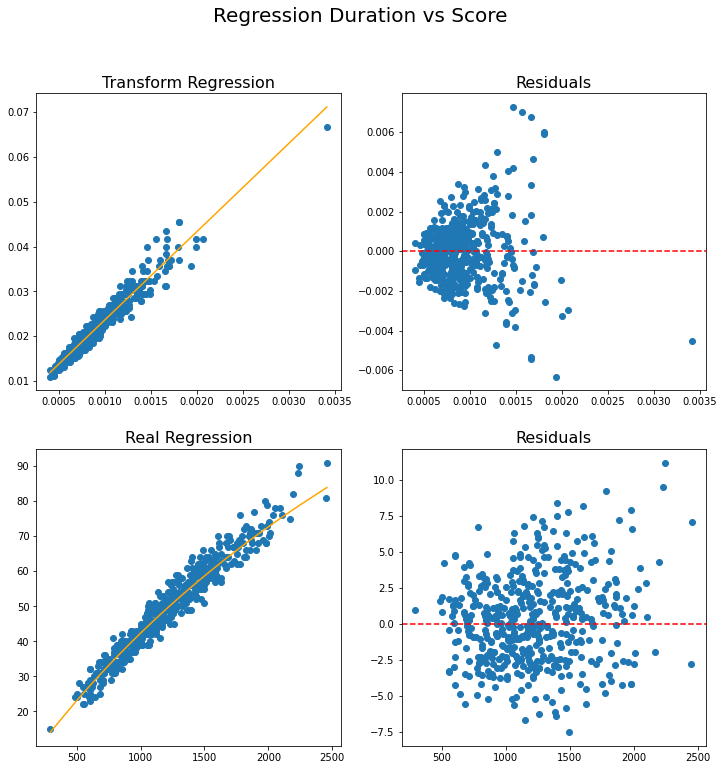

In [124]:
transform_4, real_4, x_4 = transformRegression(steps_4,score_4)

In [75]:
duration_diff_4 = time_diff(games_4)

In [76]:
duration_diff_4 = delete_outliers(duration_diff_4)

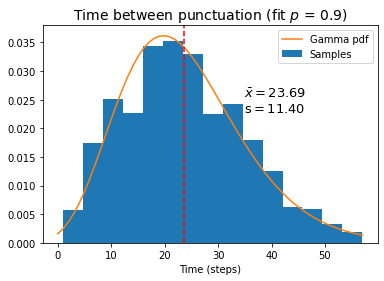

In [77]:
pdf_4 = gamma_aproximation(duration_diff_4)

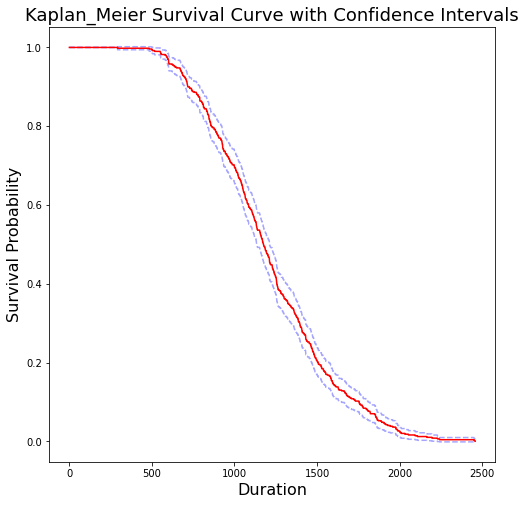

In [78]:
up_4, down_4, probs_4, steps_range_4 = survival_analysis(steps_4)

## Fifth Reward 

### Data from training 

In [ ]:
general_sample_visualization(paths, 5)
average_comparative(paths, 5)

### Samples of each iteration

In [79]:
df_5 = samples_per_iteration(5,500)

/usr/lib/python3/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/lib/python3/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


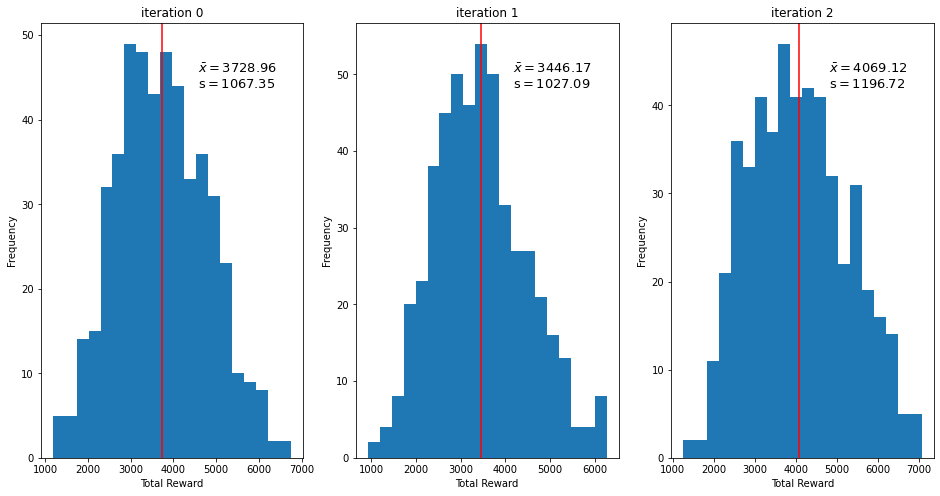

In [80]:
delete_outliers_df(df_5)
histogram(df_5,20)

In [81]:
checkNormalityModels(df_5)

The iteration 0 is normal with 0.01093061423395378 of confidence
The iteration 1 is normal with 0.12369044481469438 of confidence
The iteration 2 is normal with 0.07067783179235335 of confidence


In [82]:
anovaTestModels(df_5)

F_onewayResult(statistic=39.78717316751947, pvalue=1.4752840787433892e-17)


In [83]:
games_5 = sampler(SNAKE_GAMES[0], REWARDS[5], 5, 0, 500, True)

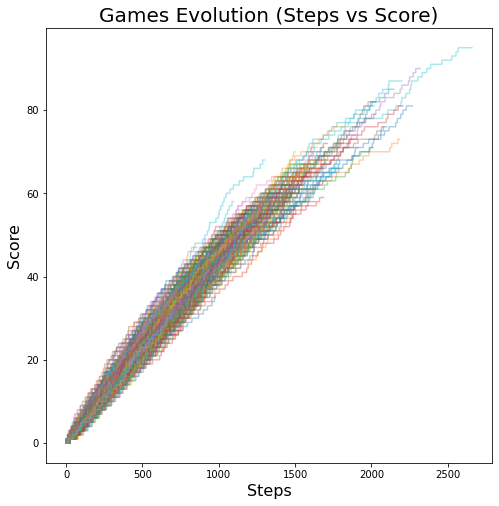

In [84]:
plotPathGames(games_5)

In [85]:
steps_5, score_5 = stepsScoreValues(games_5)

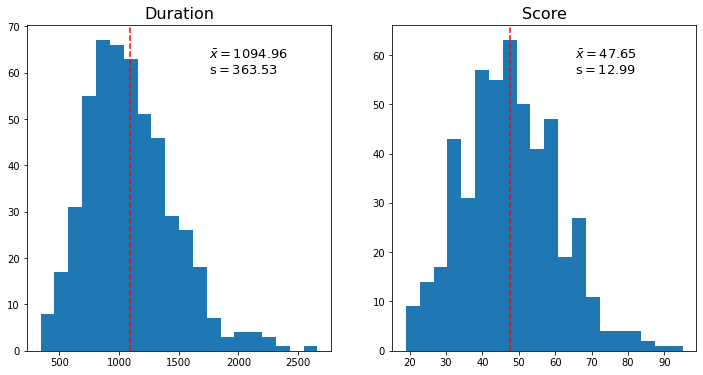

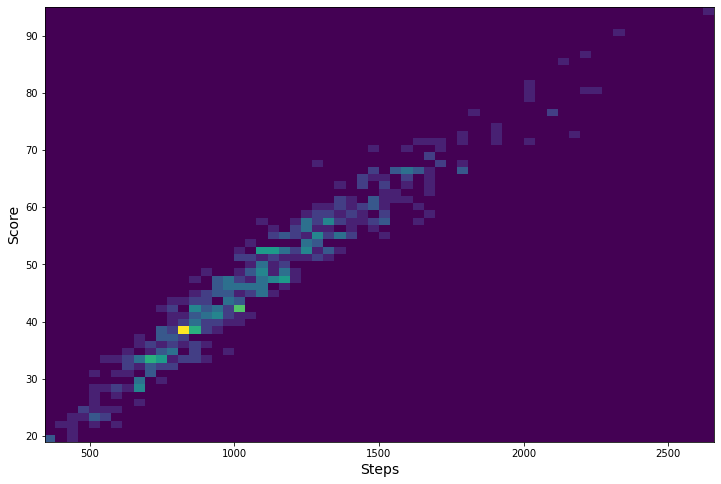

In [86]:
response_histogram(steps_5, score_5)

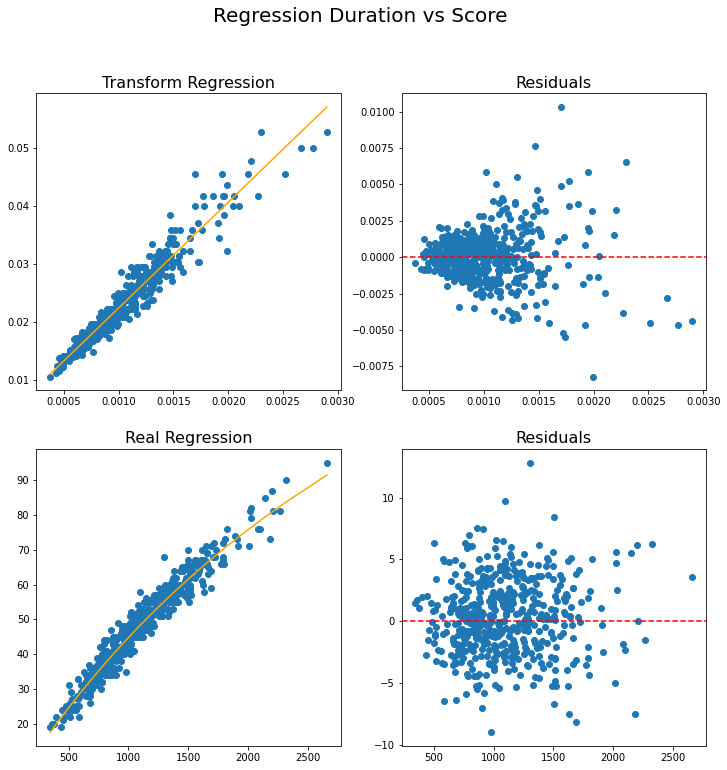

In [125]:
transform_5, real_5, x_5 = transformRegression(steps_5,score_5)

In [88]:
duration_diff_5 = time_diff(games_5)

In [89]:
duration_diff_5 = delete_outliers(duration_diff_5)

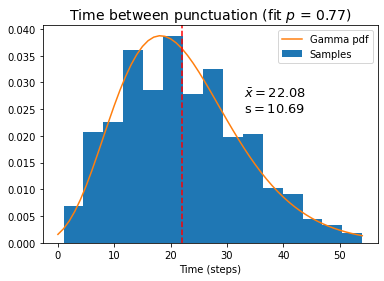

In [90]:
pdf_5 = gamma_aproximation(duration_diff_5)

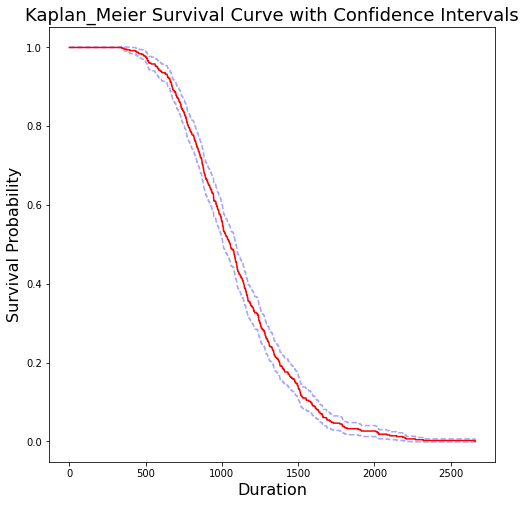

In [91]:
up_5, down_5, probs_5, steps_range_5 = survival_analysis(steps_5)

## Comparation between policies

The easiest way to compare the results is using the same graphs that we already used, having into account what each chart tell us and how it works.

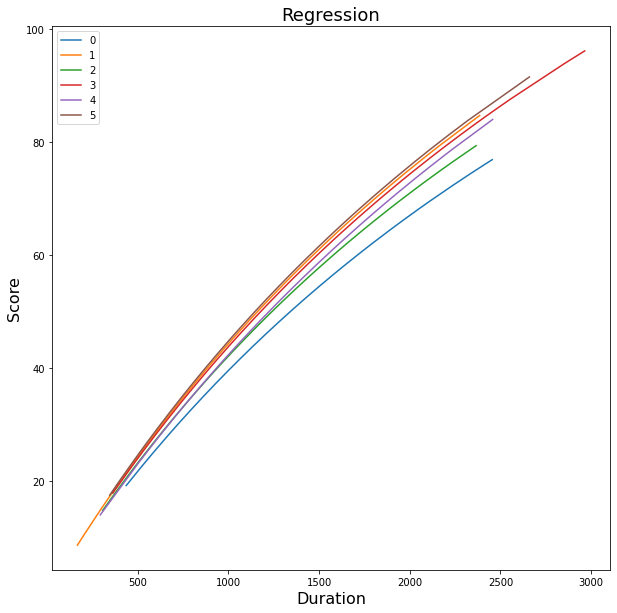

In [139]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(steps_0,real_0, label='0')
ax.plot(steps_1,real_1, label='1')
ax.plot(steps_2,real_2, label='2')
ax.plot(steps_3,real_3, label='3')
ax.plot(steps_4,real_4, label='4')
ax.plot(steps_5,real_5, label='5')
ax.set_title('Regression', fontsize=18)
ax.set_xlabel('Duration', fontsize=16)
ax.set_ylabel('Score', fontsize=16)
ax.legend()

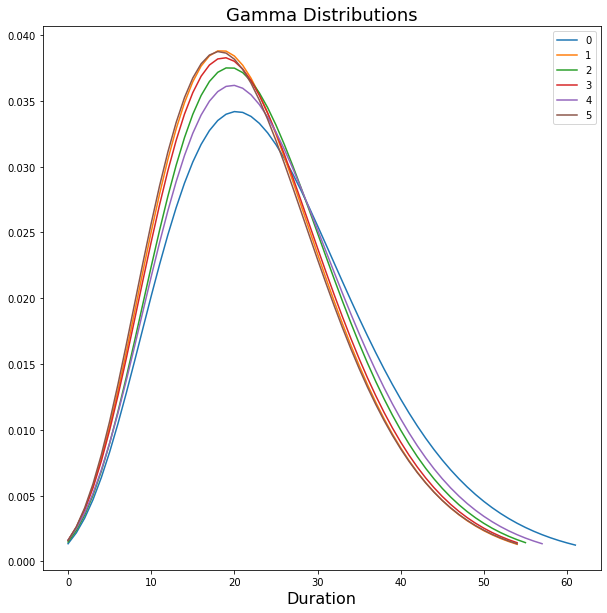

In [140]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(pdf_0, label='0')
ax.plot(pdf_1, label='1')
ax.plot(pdf_2, label='2')
ax.plot(pdf_3, label='3')
ax.plot(pdf_4, label='4')
ax.plot(pdf_5, label='5')
ax.set_title('Gamma Distributions', fontsize=18)
ax.set_xlabel('Duration', fontsize=16)
ax.legend()

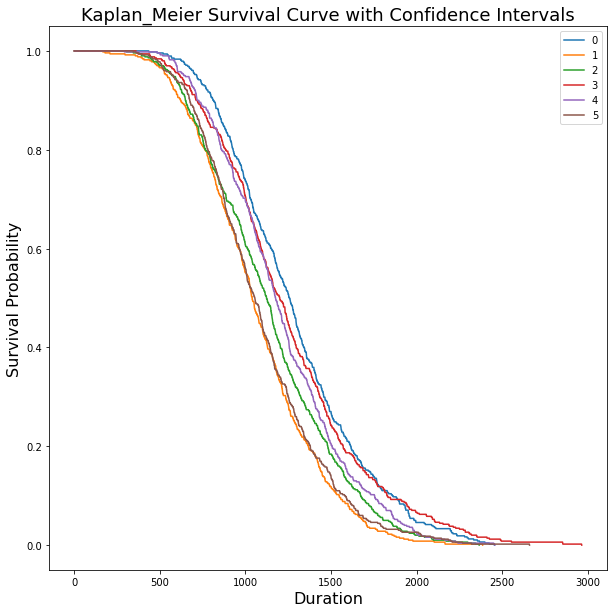

In [111]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(steps_range, probs, label='0')
ax.plot(steps_range_1, probs_1, label='1')
ax.plot(steps_range_2, probs_2, label='2')
ax.plot(steps_range_3, probs_3, label='3')
ax.plot(steps_range_4, probs_4, label='4')
ax.plot(steps_range_5, probs_5, label='5')
ax.set_title('Kaplan_Meier Survival Curve', fontsize=18)
ax.set_xlabel('Duration', fontsize=16)
ax.set_ylabel('Survival Probability', fontsize=16)
ax.legend()

As I mentioned before the analyses is related between them and knowing that now we can use them to make decisions. The first thing we need to define is what are we looking for?, the fastest player?, the most reliable one?, or maybe the player that probably could get the maximum score?, this is a decision that each one has to take. I decide that the best "player" will be the most outstanding generally speaking.

As I mentioned the regression is the most complete analysis of the three because relates the score and the duration of the game also I left the regression only for the existing values from samples that means we are looking at the maximums and minimums (in terms of time). We can see the 6 policies split into two groups, the upper group (1, 3, 5) and the other (0, 2, 4), at a first sight the upper group are almost equal between them less than 5% (comparing the slopes), even in the gamma distribution so the speed to get points is similar, almost 2%, (although all the distributions are almost equaled, the biggest difference is about 12%), finally looking at the survival analysis give us the last signal to choose the best policy, although the first two analyses give us similar results in this one, one of the 3 policies is remarkably better than the other two (1, 5) around 15%, so picking the 3 policie have the biggest probability to endure 15% more steps than the 1, 5 policies and have a nice relationship between the time and the score among the policies.

After having chosen the "best" policy we can study further what characteristics have the policies to expose that behavior. Policies 1,3, and 5 are :

- (1) { 'aprox': [1,0],
    'eat':[10,0],
    'dead':[-10, 0]
  }
- (3) { 'aprox': [3,-1],
    'eat':[10,0],
    'dead':[-100, 0]
  }
- (5) { 'aprox': [3,-1],
    'eat':[20,0],
    'dead':[-10, 0]
  }

The way the model decides to risk or not depends on the relation cost-benefit. Policies 1 and 5 have less punishment each time the player dies so the risk of take a dangerous decision is also less, on the other hand, policies 3 and 5 have a higher reward when the player approximate the "prey" but policy 3 have the higher punishment when it dies, this could lead to a more conservative way of playing. When we look at the results the 5 policy (the conservative one) endures more than the policies 1 and 3 but have a minor performance because it won't take many risky moves that would make the player lose the match.

The way to select the perfect policy is a complicated and large process that needs to take into account how we would like the model to play the game and which parameters we need to use with its respective values (reward and punish). In this case, I took a lot of simplifications, especially in the network architecture and training because of my limited resources and to focus only on the analysis. The results presented here could improve significantly using a more complicated architecture likes LSTM, increasing the size of the data buffer and the time of each match because now is limited to only 30000 steps, this could lead to a bias buffer with defined limits (in this case matches around 3000 steps).